# Read Data

In [1]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/TokenGT/data/output-dgi-10-10-20MAY2025.h5ad"
)
adata = adata[adata.layers["transcript"].sum(axis=1) > 100].copy()
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])

adata.X = adata.layers["transcript"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
adata.X seems to be already log-transformed.


In [30]:
from scipy.spatial import cKDTree
adata.obs["z_centroid"] = adata.obs["folder"].replace({
    k: i * 10_000
    for i, k in enumerate(adata.obs["folder"].unique())
})

ckd_tree = cKDTree(adata.obs[["x_centroid", "y_centroid", "z_centroid"]])

_, neighbor_indicies = ckd_tree.query(adata.obs[["x_centroid", "y_centroid", "z_centroid"]], k = 30)
neighbor_indicies = neighbor_indicies.tolist()

/tmp/ipykernel_3995046/4276166334.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs["z_centroid"] = adata.obs["folder"].replace({
/tmp/ipykernel_3995046/4276166334.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["z_centroid"] = adata.obs["folder"].replace({


# Data Set 

In [3]:
import torch

class SpatialSingleCellDataSet:
    
    def __init__(
        self, 
        counts,
        log_normalized,
        plin2_area,
        oil_red_o_area,
        lipid_droplet_area,
        near_amyloid,
        neighbor_indices,
        specimen_ids
    ):
        # Gene Expression Information
        self.counts = self._to_tensor(counts, torch.float)
        self.log_normalized = self._to_tensor(log_normalized, torch.float)

        self.size_factors = (self.counts.sum(axis=1) / self.counts.sum(axis=1).mean()).log()

        # Pathology Information
        self.plin2_area = self._to_tensor(plin2_area, torch.float)
        self.oil_red_o_area = self._to_tensor(oil_red_o_area, torch.float)
        self.lipid_droplet_area = self._to_tensor(lipid_droplet_area, torch.float)
        self.near_amyloid = self._to_tensor(near_amyloid, torch.float)

        # Neighborhood Information
        self.specimen_ids = self._to_tensor(specimen_ids, torch.long)
        self.neighbor_indices = self._to_tensor(neighbor_indices, torch.long)

    @staticmethod
    def _to_tensor(x, dtype=torch.float):
        if isinstance(x, torch.Tensor):
            return x.detach().clone().to(dtype)
        else:
            return torch.tensor(x, dtype=dtype)

    def __len__(self):
        return self.counts.size(0)

    def __getitem__(self, idx):
        return {
            # Expression Information
            "counts": self.counts[idx],
            "log_normalized": self.log_normalized[idx],
            "size_factors": self.size_factors[idx],

            # Pathology Information
            "plin2_area": self.plin2_area[idx],
            "oil_red_o_area": self.oil_red_o_area[idx],
            "lipid_droplet_area": self.lipid_droplet_area[idx],
            "near_amyloid": self.near_amyloid[idx],

            # Neighborhood Information
            "neighbor_indices": self.neighbor_indices[idx],

            # Cell Metadata
            "specimen_ids": self.specimen_ids[idx],
        }

counts = torch.tensor(adata.layers["transcript"])
log_normalized = torch.tensor(adata.X)

plin2_area = torch.tensor(adata.obs["plin2_area"].values).log1p()
oil_red_o_area = torch.tensor(adata.obs["oil_red_o_area"].values).log1p()
lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values).log1p()
near_amyloid = torch.tensor(adata.obs["near_amyloid"].values).float()

neighbor_indices = torch.tensor(neighbor_indicies)
specimen_ids = torch.tensor(adata.obs["folder"].cat.codes.values)

dataset = SpatialSingleCellDataSet(
    counts,
    log_normalized,
    plin2_area,
    oil_red_o_area,
    lipid_droplet_area,
    near_amyloid,
    neighbor_indices,
    specimen_ids
)

input_data = dataset[0]

dataset[input_data["neighbor_indices"]]

{'counts': tensor([[2., 0., 2.,  ..., 2., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 2.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]),
 'log_normalized': tensor([[0.7922, 0.0000, 0.7922,  ..., 0.7922, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9430],
         [0.0000, 0.0000, 0.8157,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3331, 0.0000, 0.5825,  ..., 0.3331, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5085,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0707, 0.0000]]),
 'size_factors': tensor([ 0.3461, -0.6074, -0.3897,  0.3035, -0.0594,  0.4638, -0.3163,  0.0230,
         -0.4398,  0.7704,  0.2533, -0.8088]),
 'plin2_area': tensor([4.7786, 0.0000, 0.0000, 0.3542, 0.0000, 0.6152, 2.3370, 2.8041, 0.0000,
         4.2310, 2.1818, 0.0000]),
 'oil_red_o_area': tensor([6.1

In [4]:
import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F

# Gradient Reversal Layer implementation
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Identity forward pass

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

# Variational Encoder (unchanged)
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, embedding_dim)
        self.log_var = nn.Linear(hidden_dim, embedding_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.shared(x)
        log_mu = self.mu(h)
        log_var = self.log_var(h)
        return log_mu, log_var

In [5]:

# Spatial Decoder (same as before, you can copy your existing decoder here)
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_genes, n_batches):
        super().__init__()
        self.batch_emb = nn.Embedding(n_batches, embedding_dim)
        self.shared = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU()
        )
        self.nb_mu = nn.Linear(hidden_dim, n_genes)
        self.log_theta = nn.Parameter(torch.zeros(1))
        self.hurdle_logits = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_mu = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_log_var = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.near_amyloid_logit = nn.Linear(hidden_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z, specimen_ids):
        batch_embedding = self.batch_emb(specimen_ids)
        h = self.shared(torch.cat([z, batch_embedding], dim=-1))
        log_mu_counts = self.nb_mu(h)
        log_theta = self.log_theta.expand_as(log_mu_counts)
        hurdle_out = {}
        for k in self.hurdle_logits.keys():
            hurdle_out[k] = {
                "logit_p": self.hurdle_logits[k](h),
                "mu": self.hurdle_mu[k](h),
                "log_var": self.hurdle_log_var[k](h)
            }
        near_amyloid_logit = self.near_amyloid_logit(h)
        return {
            "log_mu_counts": log_mu_counts,
            "log_theta": log_theta,
            "hurdle": hurdle_out,
            "near_amyloid_logit": near_amyloid_logit
        }

In [6]:
# Discriminator to predict specimen_ids from latent z
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_batches):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_batches)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        return self.net(z)


In [7]:
# Full VAE with adversarial batch correction
class VAEWithAdversarial(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, n_genes, n_batches):
        super().__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, n_genes, n_batches)
        self.discriminator = Discriminator(embedding_dim, hidden_dim // 2, n_batches)

    def reparameterize(self, log_mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return log_mu + eps * std

    def forward(self, input_data):
        x = input_data["log_normalized"]
        specimen_ids = input_data["specimen_ids"]

        log_mu, log_var = self.encoder(x)
        z = self.reparameterize(log_mu, log_var)

        outputs = self.decoder(z, specimen_ids)
        outputs["size_factors"] = input_data["size_factors"]
        return outputs, log_mu, log_var, z

    def discriminate(self, z, lambda_grl=1.0):
        # Apply gradient reversal on z before discriminator
        z_rev = grad_reverse(z, lambda_grl)
        logits = self.discriminator(z_rev)
        return logits


In [14]:
import torch
import torch.nn.functional as F

# 1) Negative Binomial loss for counts

def negative_binomial_loss(x, log_mu, log_theta, size_factors):
    """
    x: observed counts (integer tensor)
    log_mu: decoded log mean (float tensor)
    log_theta: scalar or tensor, shared dispersion (log scale)
    size_factors: tensor, log scale size factors (same shape as batch size)
    """
    # Adjust log_mu by adding size factors (log scale)
    # size_factors shape: (batch_size,)
    # log_mu shape: (batch_size, n_genes)
    log_mu_adj = log_mu + size_factors.unsqueeze(-1)  # broadcast size_factors

    theta = torch.exp(log_theta)  # dispersion

    # logits for NB parameterization: logits = log_mu - log(mu + theta)
    logits = log_mu_adj - torch.log(torch.exp(log_mu_adj) + theta)

    nb_dist = torch.distributions.NegativeBinomial(total_count=theta, logits=logits)
    # Negative log likelihood (sum over genes and batch)
    neg_log_likelihood = -nb_dist.log_prob(x).sum()

    return neg_log_likelihood


# 2) Hurdle normal loss for each pathology feature

def hurdle_normal_loss(x, logit_p, mu, log_var):
    p = torch.sigmoid(logit_p)
    is_zero = (x == 0).float()

    bern_loss = -(is_zero * torch.log(1 - p + 1e-8) + (1 - is_zero) * torch.log(p + 1e-8))

    std = torch.exp(0.5 * log_var)
    const = torch.log(torch.tensor(2 * torch.pi, device=x.device, dtype=x.dtype))
    gaussian_nll = 0.5 * ( ((x - mu) / std) ** 2 + 2 * torch.log(std) + const )
    gaussian_nll = gaussian_nll * (1 - is_zero)

    total_loss = (bern_loss + gaussian_nll).sum()
    return total_loss


# 3) Logistic loss for near_amyloid (binary classification)

def near_amyloid_loss(logits, labels):
    """
    logits: raw logits output from decoder (before sigmoid)
    labels: binary labels (0/1 float tensor)
    """
    loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), labels, reduction='sum')
    return loss


# 4) KL divergence between latent posterior and prior

def kl_divergence(log_mu, log_var):
    """
    Standard VAE KL divergence
    """
    kl = -0.5 * torch.sum(1 + log_var - log_mu.pow(2) - log_var.exp())
    return kl

def discriminator_loss(discriminator_logits, specimen_ids):
    """
    Cross-entropy loss for discriminator predicting specimen_ids.
    """
    return F.cross_entropy(discriminator_logits, specimen_ids)

def compute_total_loss(
    outputs,
    input_data,
    log_mu,
    log_var,
    discriminator_logits=None,
    weight_kl=1.0,
    weight_nb=1.0,
    weight_hurdle=1.0,
    weight_amyloid=1.0,
    weight_adv=0.0,
):
    """
    Computes total loss for VAE model, optionally including adversarial loss.

    If `discriminator_logits` is provided, compute adversarial loss and include weighted in total loss.
    """

    # Negative Binomial loss (counts)
    nb_loss = negative_binomial_loss(
        x=input_data["counts"],
        log_mu=outputs["log_mu_counts"],
        log_theta=outputs["log_theta"],
        size_factors=input_data["size_factors"]
    )

    # Hurdle normal losses (sum over 3 features)
    hurdle_loss = 0.0
    for key in ["plin2", "oil_red_o", "lipid_droplet"]:
        h = outputs["hurdle"][key]
        x = input_data[f"{key}_area"]
        hurdle_loss += hurdle_normal_loss(x, h["logit_p"], h["mu"], h["log_var"])

    # Near amyloid logistic loss
    amyloid_loss = near_amyloid_loss(outputs["near_amyloid_logit"], input_data["near_amyloid"])

    # KL divergence
    kl_loss = kl_divergence(log_mu, log_var)

    # Adversarial loss (optional)
    if discriminator_logits is not None:
        adv_loss = discriminator_loss(discriminator_logits, input_data["specimen_ids"])
    else:
        adv_loss = torch.tensor(0.0, device=log_mu.device)

    # Total loss
    total_loss = (
        weight_nb * nb_loss
        + weight_hurdle * hurdle_loss
        + weight_amyloid * amyloid_loss
        + weight_kl * kl_loss
        + weight_adv * adv_loss
    )

    return total_loss, {
        "total_loss": total_loss.item(),
        "nb_loss": nb_loss.item(),
        "hurdle_loss": hurdle_loss.item(),
        "amyloid_loss": amyloid_loss.item(),
        "kl_loss": kl_loss.item(),
        "adv_loss": adv_loss.item() if isinstance(adv_loss, torch.Tensor) else adv_loss
    }


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 4096
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

vae = VAEWithAdversarial(
    input_dim=366,
    hidden_dim=64,
    embedding_dim=16,
    n_genes=366,
    n_batches=12
).to(device)
vae.train()

discriminator = Discriminator(embedding_dim=16, hidden_dim=32, n_batches=12).to(device)
discriminator.train()

optimizer_vae = Adam(vae.parameters(), lr=1e-3)
optimizer_disc = Adam(discriminator.parameters(), lr=1e-3)

num_epochs = 1_000
adv_weight = 1.0
lambda_grl = 1.0

Using device: cuda
Epoch [1/1000], Batch [0], Loss: 395405856.0000, Disc Loss: 2.6510
Epoch [1/1000], Batch [10], Loss: 148695456.0000, Disc Loss: 2.3292
Epoch [1/1000], Batch [20], Loss: 112780056.0000, Disc Loss: 2.2900
Epoch [1/1000], Batch [30], Loss: 109055880.0000, Disc Loss: 2.2777
Epoch [1/1000], Batch [40], Loss: 101965536.0000, Disc Loss: 2.2459
Epoch [1/1000], Batch [50], Loss: 99425712.0000, Disc Loss: 2.2459
Epoch [1/1000], Batch [60], Loss: 96016520.0000, Disc Loss: 2.2299
Epoch [1/1000], Batch [70], Loss: 94881792.0000, Disc Loss: 2.2205
Epoch [1/1000], Batch [80], Loss: 94610480.0000, Disc Loss: 2.2234
Epoch [1/1000], Batch [90], Loss: 93102456.0000, Disc Loss: 2.2100
Epoch [1/1000], Batch [100], Loss: 93862168.0000, Disc Loss: 2.2059
Epoch [1/1000] Average Loss: 114996275.9615
Epoch [2/1000], Batch [0], Loss: 93374472.0000, Disc Loss: 2.1997
Epoch [2/1000], Batch [10], Loss: 93486120.0000, Disc Loss: 2.1821
Epoch [2/1000], Batch [20], Loss: 93121032.0000, Disc Loss: 2.

KeyboardInterrupt: 

In [23]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, batch_samples in enumerate(data_loader):
        # Convert list of dicts to dict of batched tensors and send to device
        batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

        # --- Step 1: Train discriminator ---
        for i in range(20):
            optimizer_disc.zero_grad()
            with torch.no_grad():
                log_mu, log_var = vae.encoder(batch_data["log_normalized"])
                z = vae.reparameterize(log_mu, log_var)

            disc_logits = discriminator(z.detach())
            disc_loss = torch.nn.functional.cross_entropy(disc_logits, batch_data["specimen_ids"])
            disc_loss.backward()
            optimizer_disc.step()

        # --- Step 2: Train VAE ---
        optimizer_vae.zero_grad()

        log_mu, log_var = vae.encoder(batch_data["log_normalized"])
        z = vae.reparameterize(log_mu, log_var)

        outputs = vae.decoder(z, batch_data["specimen_ids"])
        outputs["size_factors"] = batch_data["size_factors"]

        z_rev = grad_reverse(z, lambda_grl)
        adv_logits = discriminator(z_rev)

        loss, loss_items = compute_total_loss(
            outputs=outputs,
            input_data=batch_data,
            log_mu=log_mu,
            log_var=log_var,
            discriminator_logits=adv_logits,
            weight_adv=adv_weight
        )

        loss.backward()
        optimizer_vae.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

Epoch [1/1000], Batch [0], Loss: 90348624.0000, Disc Loss: 2.0386
Epoch [1/1000], Batch [10], Loss: 90760672.0000, Disc Loss: 2.0456
Epoch [1/1000], Batch [20], Loss: 90578824.0000, Disc Loss: 2.0277
Epoch [1/1000], Batch [30], Loss: 90444584.0000, Disc Loss: 2.0411
Epoch [1/1000], Batch [40], Loss: 91362992.0000, Disc Loss: 2.0384
Epoch [1/1000], Batch [50], Loss: 90893680.0000, Disc Loss: 2.0303
Epoch [1/1000], Batch [60], Loss: 90065576.0000, Disc Loss: 2.0211
Epoch [1/1000], Batch [70], Loss: 90726776.0000, Disc Loss: 2.0211
Epoch [1/1000], Batch [80], Loss: 90388472.0000, Disc Loss: 1.9983
Epoch [1/1000], Batch [90], Loss: 89657256.0000, Disc Loss: 2.0388
Epoch [1/1000], Batch [100], Loss: 90735424.0000, Disc Loss: 1.9959
Epoch [1/1000] Average Loss: 89885031.9231
Epoch [2/1000], Batch [0], Loss: 90434112.0000, Disc Loss: 2.0210
Epoch [2/1000], Batch [10], Loss: 90832360.0000, Disc Loss: 1.9862
Epoch [2/1000], Batch [20], Loss: 90001776.0000, Disc Loss: 2.0173
Epoch [2/1000], Batc

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7408e9a46f90>>
Traceback (most recent call last):
  File "/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Epoch [48/1000], Batch [30], Loss: 90865416.0000, Disc Loss: 2.0182
Epoch [48/1000], Batch [40], Loss: 90838104.0000, Disc Loss: 2.0163
Epoch [48/1000], Batch [50], Loss: 90478304.0000, Disc Loss: 1.9934
Epoch [48/1000], Batch [60], Loss: 90313080.0000, Disc Loss: 1.9988
Epoch [48/1000], Batch [70], Loss: 90500992.0000, Disc Loss: 1.9869
Epoch [48/1000], Batch [80], Loss: 90430320.0000, Disc Loss: 1.9996
Epoch [48/1000], Batch [90], Loss: 90466784.0000, Disc Loss: 2.0063
Epoch [48/1000], Batch [100], Loss: 90270696.0000, Disc Loss: 2.0104
Epoch [48/1000] Average Loss: 89809016.0385
Epoch [49/1000], Batch [0], Loss: 90835584.0000, Disc Loss: 1.9975
Epoch [49/1000], Batch [10], Loss: 89709128.0000, Disc Loss: 1.9669
Epoch [49/1000], Batch [20], Loss: 90686264.0000, Disc Loss: 2.0271
Epoch [49/1000], Batch [30], Loss: 90697832.0000, Disc Loss: 1.9969
Epoch [49/1000], Batch [40], Loss: 90972464.0000, Disc Loss: 2.0100
Epoch [49/1000], Batch [50], Loss: 91365632.0000, Disc Loss: 2.0246
Epoc

KeyboardInterrupt: 

In [24]:
import torch
from torch.utils.data import DataLoader

def extract_embeddings(model, dataset, batch_size=256, use_mean=True, device=None):
    """
    Extract latent embeddings for all samples in `dataset`.

    Args:
        model: trained VAE model with encoder
        dataset: dataset object (e.g. SpatialSingleCellDataSet)
        batch_size: batch size for DataLoader
        use_mean: if True, use encoder's mean (log_mu) as embedding,
                  else sample from latent distribution
        device: torch device (e.g. 'cuda' or 'cpu'), default auto-detect

    Returns:
        embeddings: Tensor of shape (n_samples, embedding_dim)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

    all_embeddings = []

    with torch.no_grad():
        for batch_samples in loader:
            batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

            log_mu, log_var = model.encoder(batch_data["log_normalized"])

            if use_mean:
                embeddings = log_mu
            else:
                std = torch.exp(0.5 * log_var)
                eps = torch.randn_like(std)
                embeddings = log_mu + eps * std

            all_embeddings.append(embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

token_embeddings = extract_embeddings(vae, dataset)

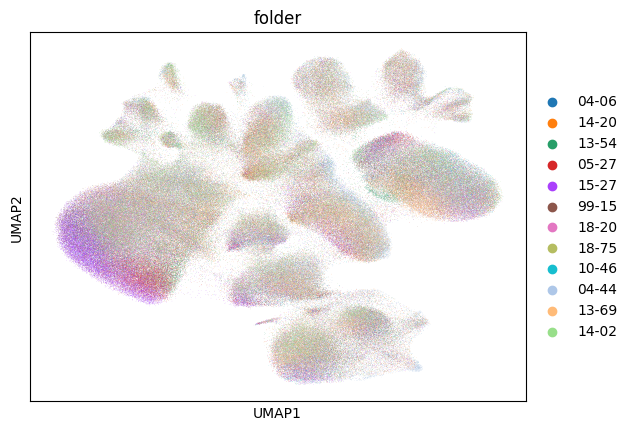

In [25]:
adata.obsm["X_token"] = token_embeddings.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep="X_token")
sc.tl.umap(adata)
sc.pl.umap(adata, color="folder")

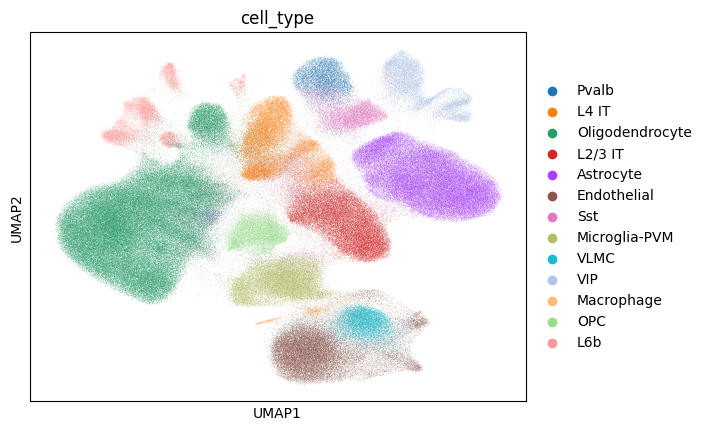

In [26]:
sc.pl.umap(adata, color="cell_type")

# Embeddings

In [31]:
import torch
from torch.utils.data import Dataset

class SpatialEmbeddingDataset(Dataset):
    def __init__(self, embeddings, neighbor_indices):
        """
        Args:
            embeddings: Tensor of shape (n_cells, embedding_dim)
            neighbor_indices: LongTensor of shape (n_cells, n_neighbors)
        """
        self.embeddings = embeddings
        self.neighbor_indices = neighbor_indices

    def __len__(self):
        return self.embeddings.size(0)

    def __getitem__(self, idx):
        """
        Returns:
            {
                "center": embedding of center cell (embedding_dim,),
                "neighbors": embeddings of neighbors (n_neighbors, embedding_dim),
                "center_idx": index of the center cell
            }
        """
        center_embedding = self.embeddings[idx]
        neighbor_idxs = self.neighbor_indices[idx]
        neighbor_embeddings = self.embeddings[neighbor_idxs]

        return {
            "center": center_embedding,
            "neighbors": neighbor_embeddings,
            "center_idx": idx
        }

spatial_embedding_dataset = SpatialEmbeddingDataset(
    embeddings=token_embeddings,
    neighbor_indices=neighbor_indices[:, 1:]
)

In [32]:
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

def build_simple_flow(embedding_dim, n_transforms=4, hidden_dim=64):
    base_dist = StandardNormal([embedding_dim])
    transforms = []
    for _ in range(n_transforms):
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=embedding_dim,
                hidden_features=hidden_dim
            )
        )
    # Combine into a proper composite transform
    transform = CompositeTransform(transforms)
    return Flow(transform, base_dist)


In [ ]:
import torch
from torch import nn
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform


def build_conditional_flow(embedding_dim, context_dim, n_transforms=4, hidden_dim=64):
    """
    Builds a conditional normalizing flow: p(x | context)
    """
    base_dist = StandardNormal([embedding_dim])
    transforms = []
    for _ in range(n_transforms):
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=embedding_dim,
                hidden_features=hidden_dim,
                context_features=context_dim
            )
        )
    return Flow(CompositeTransform(transforms), base_dist)


class SpatialTransformerFlow(nn.Module):
    def __init__(self, embedding_dim, n_heads=4, n_layers=6, n_neighbors=30,
                 n_flow_transforms=4, flow_hidden_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_neighbors = n_neighbors

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Learnable positional encoding
        self.positional_enc = nn.Parameter(torch.randn(1, n_neighbors + 2, embedding_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=embedding_dim * 4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Conditional flow: p(next_token | context)
        self.flow = build_conditional_flow(
            embedding_dim=embedding_dim,
            context_dim=embedding_dim,
            n_transforms=n_flow_transforms,
            hidden_dim=flow_hidden_dim
        )

    def forward(self, center, neighbors, kl_weight=1.0, start_step=0):
        """
        center:      (B, embedding_dim)
        neighbors:   (B, n_neighbors, embedding_dim)
        kl_weight:   weight on KL regularization
        start_step:  index to start predicting neighbors (0-based)
        Returns:
            log_probs: (B, n_steps) - conditional log-likelihoods
            kl_loss:   scalar KL regularization loss
        """
        B = center.size(0)
        device = center.device

        # Start sequence: [CLS] + center
        cls_tokens = self.cls_token.expand(B, -1, -1)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []
        kl_terms = []

        for step in range(start_step, neighbors.size(1)):
            # Positional encoding + Transformer
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]
            h = self.transformer(seq)

            # Context = last token's hidden state
            context = h[:, -1, :]  # (B, D)

            # KL regularization to N(0, I): 0.5 * ||context||^2
            kl = 0.5 * (context.pow(2).sum(-1))
            kl_terms.append(kl)

            # Conditional flow likelihood: p(next_token | context)
            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token, context=context)
            all_log_probs.append(log_prob)

            # Append ground-truth neighbor for autoregressive prediction
            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)  # (B, n_steps)
        kl_terms = torch.stack(kl_terms, dim=1)

        kl_loss = kl_weight * kl_terms.mean()
        return all_log_probs, kl_loss

In [33]:
class SpatialTransformerFlow(nn.Module):
    def __init__(self, embedding_dim, n_heads=4, n_layers=6, n_neighbors=30):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_neighbors = n_neighbors

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Positional encoding (simple learnable)
        self.positional_enc = nn.Parameter(torch.randn(1, n_neighbors + 2, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=n_heads, dim_feedforward=embedding_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Normalizing Flow for predicting next-token embedding
        self.flow = build_simple_flow(embedding_dim)

    def forward(self, center, neighbors):
        """
        center: (B, embedding_dim)
        neighbors: (B, n_neighbors, embedding_dim)
        """
        B = center.size(0)
        device = center.device

        # Start with [CLS] + center
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []

        for step in range(neighbors.size(1)):
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]

            h = self.transformer(seq)  # (B, seq_len, D)
            context = h[:, -1, :]  # last token representation

            # Predict probability of the next token using the flow
            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token)  # unconditional for now
            all_log_probs.append(log_prob)

            # Append the ground truth neighbor to the sequence for next step
            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)  # (B, n_neighbors)
        return all_log_probs

def perplexity_loss(log_probs):
    """
    log_probs: (B, n_neighbors), log p(next_token)
    Returns: scalar loss (average perplexity)
    """
    nll = -log_probs  # negative log-likelihood per step
    entropy = nll.mean()  # average entropy across batch & steps
    perplexity = torch.exp(entropy)
    return perplexity

In [123]:
class SpatialTransformerFlow(nn.Module):
    def __init__(self, embedding_dim, n_heads=4, n_layers=6, n_neighbors=30):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_neighbors = n_neighbors

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Positional encoding (simple learnable)
        self.positional_enc = nn.Parameter(torch.randn(1, n_neighbors + 2, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=n_heads, dim_feedforward=embedding_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Normalizing Flow for predicting next-token embedding
        self.flow = build_simple_flow(embedding_dim)

    def forward(self, center, neighbors, kl_weight=1):
        """
        center: (B, embedding_dim)
        neighbors: (B, n_neighbors, embedding_dim)
        kl_weight: weight on the KL regularization term
        """
        B = center.size(0)
        device = center.device

        cls_tokens = self.cls_token.expand(B, -1, -1)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []
        kl_terms = []

        for step in range(neighbors.size(1)):
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]
            h = self.transformer(seq)
            context = h[:, -1, :]  # (B, D)

            # KL to standard Normal ~ 0.5 * ||z||^2
            kl = 0.5 * (context.pow(2).sum(-1))  # (B,)
            kl_terms.append(kl)

            # Flow likelihood
            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token)
            all_log_probs.append(log_prob)

            # Append next token for next step
            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)
        kl_terms = torch.stack(kl_terms, dim=1)

        # Return both pieces for the loss
        kl_loss = kl_weight * kl_terms.mean()
        return all_log_probs, kl_loss

    def forward(self, center, neighbors, kl_weight=1, start_step=0):
        """
        center: (B, embedding_dim)
        neighbors: (B, n_neighbors, embedding_dim)
        start_step: index to start predicting neighbors (0-based)
        """
        B = center.size(0)
        device = center.device

        cls_tokens = self.cls_token.expand(B, -1, -1)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []
        kl_terms = []

        # Slice neighbors to only the steps we care about
        for step in range(start_step, neighbors.size(1)):
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]
            h = self.transformer(seq)
            context = h[:, -1, :]  # (B, D)

            kl = 0.5 * (context.pow(2).sum(-1))
            kl_terms.append(kl)

            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token)
            all_log_probs.append(log_prob)

            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)
        kl_terms = torch.stack(kl_terms, dim=1)

        kl_loss = kl_weight * kl_terms.mean()
        return all_log_probs, kl_loss

In [124]:
import torch
from tqdm import tqdm
from collections import deque
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam

# --- Select device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model & Optimizer ---
model = SpatialTransformerFlow(
    embedding_dim=token_embeddings.size(1),
    n_neighbors=30
).to(device)


Using device: cuda


In [133]:
optimizer = Adam(model.parameters(), lr=1e-4)

# --- DataLoader ---
loader = DataLoader(spatial_embedding_dataset, batch_size=4096 * 2, shuffle=True)

In [134]:
from torch.utils.tensorboard import SummaryWriter
import os

# Create a logs directory (TensorBoard will read from here)
log_dir = "runs/kanna-chameleon-kl-divergence"
writer = SummaryWriter(log_dir=log_dir)

In [135]:
import torch
import numpy as np

def perturb_neighbors_order_fast(neighbors, lam=4):
    """
    neighbors: tensor of shape (B, T) or (B, T, D)
    lam: mean number of swaps per batch element (Poisson)
    
    Returns neighbors with a few swaps applied on tokens [2,...] per batch element.
    """
    neighbors = neighbors.clone()
    shape = neighbors.shape
    batch_size = shape[0]
    n_tokens = shape[1]

    max_swaps = (n_tokens - 2) // 2
    if max_swaps <= 0:
        return neighbors

    # Sample swaps per batch element
    n_swaps_per_batch = np.random.poisson(lam, size=batch_size)
    n_swaps_per_batch = np.clip(n_swaps_per_batch, 0, max_swaps)

    # Allowed indices to swap: 2..n_tokens-1
    allowed_indices = torch.arange(2, n_tokens, device=neighbors.device)

    for i in range(batch_size):
        n_swaps = n_swaps_per_batch[i]
        if n_swaps == 0:
            continue

        # Sample 2 * n_swaps distinct indices without replacement
        # Because each swap swaps 2 tokens
        swap_indices = np.random.choice(allowed_indices.cpu().numpy(), size=2*n_swaps, replace=False)
        swap_indices = torch.tensor(swap_indices, device=neighbors.device)

        # Reshape to pairs
        swap_pairs = swap_indices.view(n_swaps, 2)

        # Swap all pairs at once
        if len(shape) == 3:
            # For embeddings
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp
        else:
            # For indices
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp

        neighbors[i] = neighbors_i

    return neighbors


In [ ]:
from tqdm import tqdm
from collections import deque
import numpy as np
import torch

running_losses = deque(maxlen=50)
global_step = 0  # For TensorBoard x-axis

scaler = torch.cuda.amp.GradScaler()  # ✅ AMP scaler

for epoch in range(1_000):
    model.train()
    total_loss = 0.0
    epoch_pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in epoch_pbar:
        center = batch["center"].to(device, non_blocking=True)
        neighbors = batch["neighbors"].to(device, non_blocking=True)
        # neighbors = perturb_neighbors_order(neighbors)

        optimizer.zero_grad()

        # ✅ Automatic Mixed Precision
        with torch.cuda.amp.autocast():
            # log_probs = model(center, neighbors)
            log_probs, kl_divergence = model(center, neighbors)
            loss = perplexity_loss(log_probs)
            loss = loss + kl_divergence

        # ✅ Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ---- Tracking ----
        loss_val = loss.item()
        total_loss += loss_val
        running_losses.append(loss_val)
        smooth_loss = np.mean(running_losses)
        global_step += 1

        # Update tqdm bar
        epoch_pbar.set_postfix({
            "batch_loss": f"{loss_val:.4f}",
            "smooth_loss(50)": f"{smooth_loss:.4f}"
        })

        # ---- TensorBoard Logging (optional: log every N steps to reduce overhead) ----
        if global_step % 10 == 0:
            writer.add_scalar("Loss/Batch", loss_val, global_step)
            writer.add_scalar("Loss/Smooth_50", smooth_loss, global_step)

    avg_epoch_loss = total_loss / len(loader)
    writer.add_scalar("Loss/Epoch_Avg", avg_epoch_loss, epoch + 1)
    print(f"Epoch {epoch+1}: Avg Perplexity = {avg_epoch_loss:.4f}")

writer.close()  # Close at the end of training


/tmp/ipykernel_3995046/3608691455.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # ✅ AMP scaler
Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s]/tmp/ipykernel_3995046/3608691455.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 52/52 [00:19<00:00,  2.62it/s, batch_loss=13118125.0000, smooth_loss(50)=13066961.0400]


Epoch 1: Avg Perplexity = 13063103.9038


Epoch 2: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s, batch_loss=12590192.0000, smooth_loss(50)=12673263.3400]


Epoch 2: Avg Perplexity = 12678994.1346


Epoch 3: 100%|██████████| 52/52 [00:19<00:00,  2.61it/s, batch_loss=11877103.0000, smooth_loss(50)=12256888.6400]


Epoch 3: Avg Perplexity = 12261163.0000


Epoch 4: 100%|██████████| 52/52 [00:20<00:00,  2.55it/s, batch_loss=11579067.0000, smooth_loss(50)=11856939.3400]


Epoch 4: Avg Perplexity = 11858609.0000


Epoch 5: 100%|██████████| 52/52 [00:19<00:00,  2.64it/s, batch_loss=11899302.0000, smooth_loss(50)=11456439.4000]


Epoch 5: Avg Perplexity = 11476499.9038


Epoch 6: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s, batch_loss=10933855.0000, smooth_loss(50)=11092011.9200]


Epoch 6: Avg Perplexity = 11099853.4231


Epoch 7: 100%|██████████| 52/52 [00:19<00:00,  2.67it/s, batch_loss=10452917.0000, smooth_loss(50)=10736348.4000]


Epoch 7: Avg Perplexity = 10741322.8462


Epoch 8: 100%|██████████| 52/52 [00:19<00:00,  2.62it/s, batch_loss=10196412.0000, smooth_loss(50)=10394554.4000]


Epoch 8: Avg Perplexity = 10395179.1538


Epoch 9: 100%|██████████| 52/52 [00:20<00:00,  2.49it/s, batch_loss=9831957.0000, smooth_loss(50)=10053491.9400] 


Epoch 9: Avg Perplexity = 10061652.0000


Epoch 10: 100%|██████████| 52/52 [00:19<00:00,  2.61it/s, batch_loss=9808432.0000, smooth_loss(50)=9732484.9800] 


Epoch 10: Avg Perplexity = 9741041.7692


Epoch 11: 100%|██████████| 52/52 [00:20<00:00,  2.56it/s, batch_loss=8963495.0000, smooth_loss(50)=9422627.5400]


Epoch 11: Avg Perplexity = 9427968.2692


Epoch 12: 100%|██████████| 52/52 [00:20<00:00,  2.59it/s, batch_loss=8822493.0000, smooth_loss(50)=9125062.0800]


Epoch 12: Avg Perplexity = 9131598.0192


Epoch 13: 100%|██████████| 52/52 [00:20<00:00,  2.54it/s, batch_loss=8882544.0000, smooth_loss(50)=8845758.9300]


Epoch 13: Avg Perplexity = 8845407.5865


Epoch 14: 100%|██████████| 52/52 [00:19<00:00,  2.61it/s, batch_loss=8320363.5000, smooth_loss(50)=8556670.8400]


Epoch 14: Avg Perplexity = 8566770.8846


Epoch 15: 100%|██████████| 52/52 [00:20<00:00,  2.58it/s, batch_loss=8206936.0000, smooth_loss(50)=8293973.0400]


Epoch 15: Avg Perplexity = 8298925.8654


Epoch 16: 100%|██████████| 52/52 [00:19<00:00,  2.69it/s, batch_loss=7455986.0000, smooth_loss(50)=8042238.4900]


Epoch 16: Avg Perplexity = 8038932.2500


Epoch 17: 100%|██████████| 52/52 [00:20<00:00,  2.54it/s, batch_loss=7827469.5000, smooth_loss(50)=7794116.6200]


Epoch 17: Avg Perplexity = 7794086.0288


Epoch 18: 100%|██████████| 52/52 [00:19<00:00,  2.60it/s, batch_loss=7699233.0000, smooth_loss(50)=7550965.1100]


Epoch 18: Avg Perplexity = 7552988.8462


Epoch 19: 100%|██████████| 52/52 [00:19<00:00,  2.61it/s, batch_loss=7236348.0000, smooth_loss(50)=7327933.1900]


Epoch 19: Avg Perplexity = 7321372.4135


Epoch 20: 100%|██████████| 52/52 [00:20<00:00,  2.55it/s, batch_loss=7072237.5000, smooth_loss(50)=7098757.0300]


Epoch 20: Avg Perplexity = 7097916.2212


Epoch 21: 100%|██████████| 52/52 [00:19<00:00,  2.61it/s, batch_loss=6882316.5000, smooth_loss(50)=6877245.3400]


Epoch 21: Avg Perplexity = 6882660.2788


Epoch 22: 100%|██████████| 52/52 [00:20<00:00,  2.56it/s, batch_loss=6308284.5000, smooth_loss(50)=6671182.7300]


Epoch 22: Avg Perplexity = 6672655.4519


Epoch 23: 100%|██████████| 52/52 [00:19<00:00,  2.60it/s, batch_loss=6494091.0000, smooth_loss(50)=6475505.3600]


Epoch 23: Avg Perplexity = 6474372.5096


Epoch 24: 100%|██████████| 52/52 [00:20<00:00,  2.52it/s, batch_loss=6338993.0000, smooth_loss(50)=6279755.8000]


Epoch 24: Avg Perplexity = 6280332.4904


Epoch 25: 100%|██████████| 52/52 [00:19<00:00,  2.62it/s, batch_loss=6288499.5000, smooth_loss(50)=6096967.6100]


Epoch 25: Avg Perplexity = 6094914.8077


Epoch 26: 100%|██████████| 52/52 [00:20<00:00,  2.54it/s, batch_loss=5910823.0000, smooth_loss(50)=5907269.6700]


Epoch 26: Avg Perplexity = 5913358.1827


Epoch 27: 100%|██████████| 52/52 [00:19<00:00,  2.68it/s, batch_loss=5533515.5000, smooth_loss(50)=5731792.4200]


Epoch 27: Avg Perplexity = 5737332.4038


Epoch 28: 100%|██████████| 52/52 [00:20<00:00,  2.58it/s, batch_loss=5631923.0000, smooth_loss(50)=5566974.6200]


Epoch 28: Avg Perplexity = 5571000.5577


Epoch 29:  56%|█████▌    | 29/52 [00:11<00:08,  2.67it/s, batch_loss=5411516.0000, smooth_loss(50)=5463608.2100]

In [186]:

@torch.no_grad()
def extract_cls_latents(model, loader, device="cuda"):
    """
    Extracts CLS token latents for full sequences (no stepwise addition).

    Args:
        model: trained SpatialTransformerFlow
        loader: DataLoader yielding {"center", "neighbors"}
        device: device to run extraction on

    Returns:
        latents: torch.Tensor, shape (N, embedding_dim)
    """
    model.eval()
    model.to(device)
    all_latents = []

    for batch in loader:
        center = batch["center"].to(device)
        neighbors = batch["neighbors"][:, :15, :].to(device)  # (B, n_neighbors, D)
        B = center.size(0)

        # Full token sequence: [CLS] + center + neighbors
        cls_tokens = model.cls_token.expand(B, -1, -1)
        full_seq = torch.cat([cls_tokens, center.unsqueeze(1), neighbors], dim=1)

        # Add positional encoding and run transformer once
        seq = full_seq + model.positional_enc[:, :full_seq.size(1), :]
        h = model.transformer(seq)  # (B, seq_len, D)

        # CLS latent = first token's representation
        cls_latent = h[:, 0, :]
        all_latents.append(cls_latent.cpu())

    return torch.cat(all_latents, dim=0)


unshuffled_loader = DataLoader(spatial_embedding_dataset, batch_size=4096*2, shuffle=False)
cls_latents = extract_cls_latents(model, unshuffled_loader, device=device)
print(cls_latents.shape)  # (N, embedding_dim)


torch.Size([423530, 16])


In [187]:
adata.obsm["latent_representation"] = cls_latents.detach().cpu().numpy()

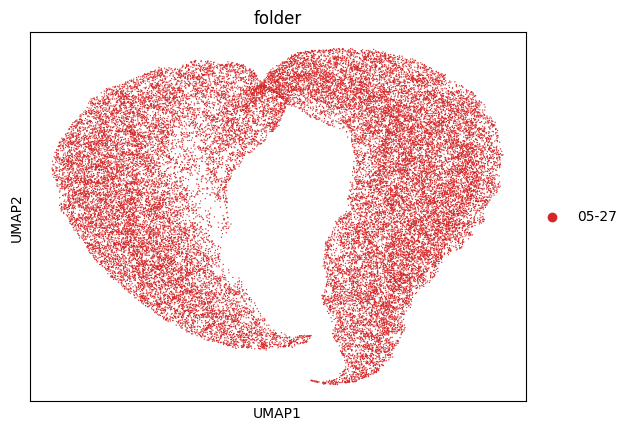

In [188]:
test_adata = adata[adata.obs["folder"].eq("05-27")]
sc.pp.neighbors(test_adata, use_rep="latent_representation")
sc.tl.umap(test_adata)
sc.pl.umap(test_adata, color="folder")

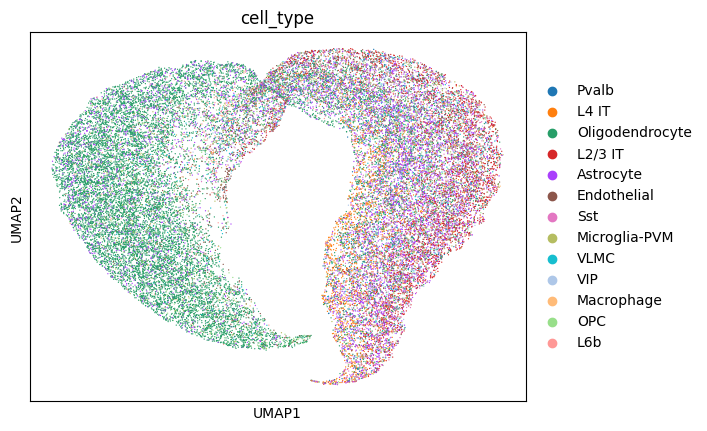

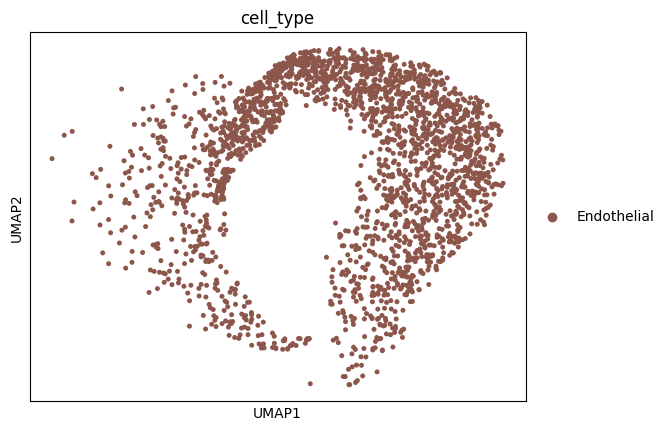

In [205]:
sc.pl.umap(test_adata, color="cell_type")
sc.pl.umap(test_adata[test_adata.obs["cell_type"].eq("Endothelial")], color="cell_type")

In [206]:
sc.tl.leiden(test_adata, resolution=.2, flavor="igraph", n_iterations=8)

<Axes: >

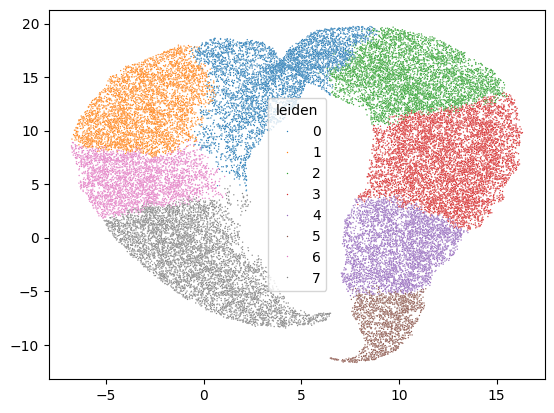

In [207]:
import seaborn as sns
sns.scatterplot(
    x=test_adata.obsm["X_umap"][:, 0],
    y=test_adata.obsm["X_umap"][:, 1],
    hue=test_adata.obs["leiden"], 
    s=1
)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

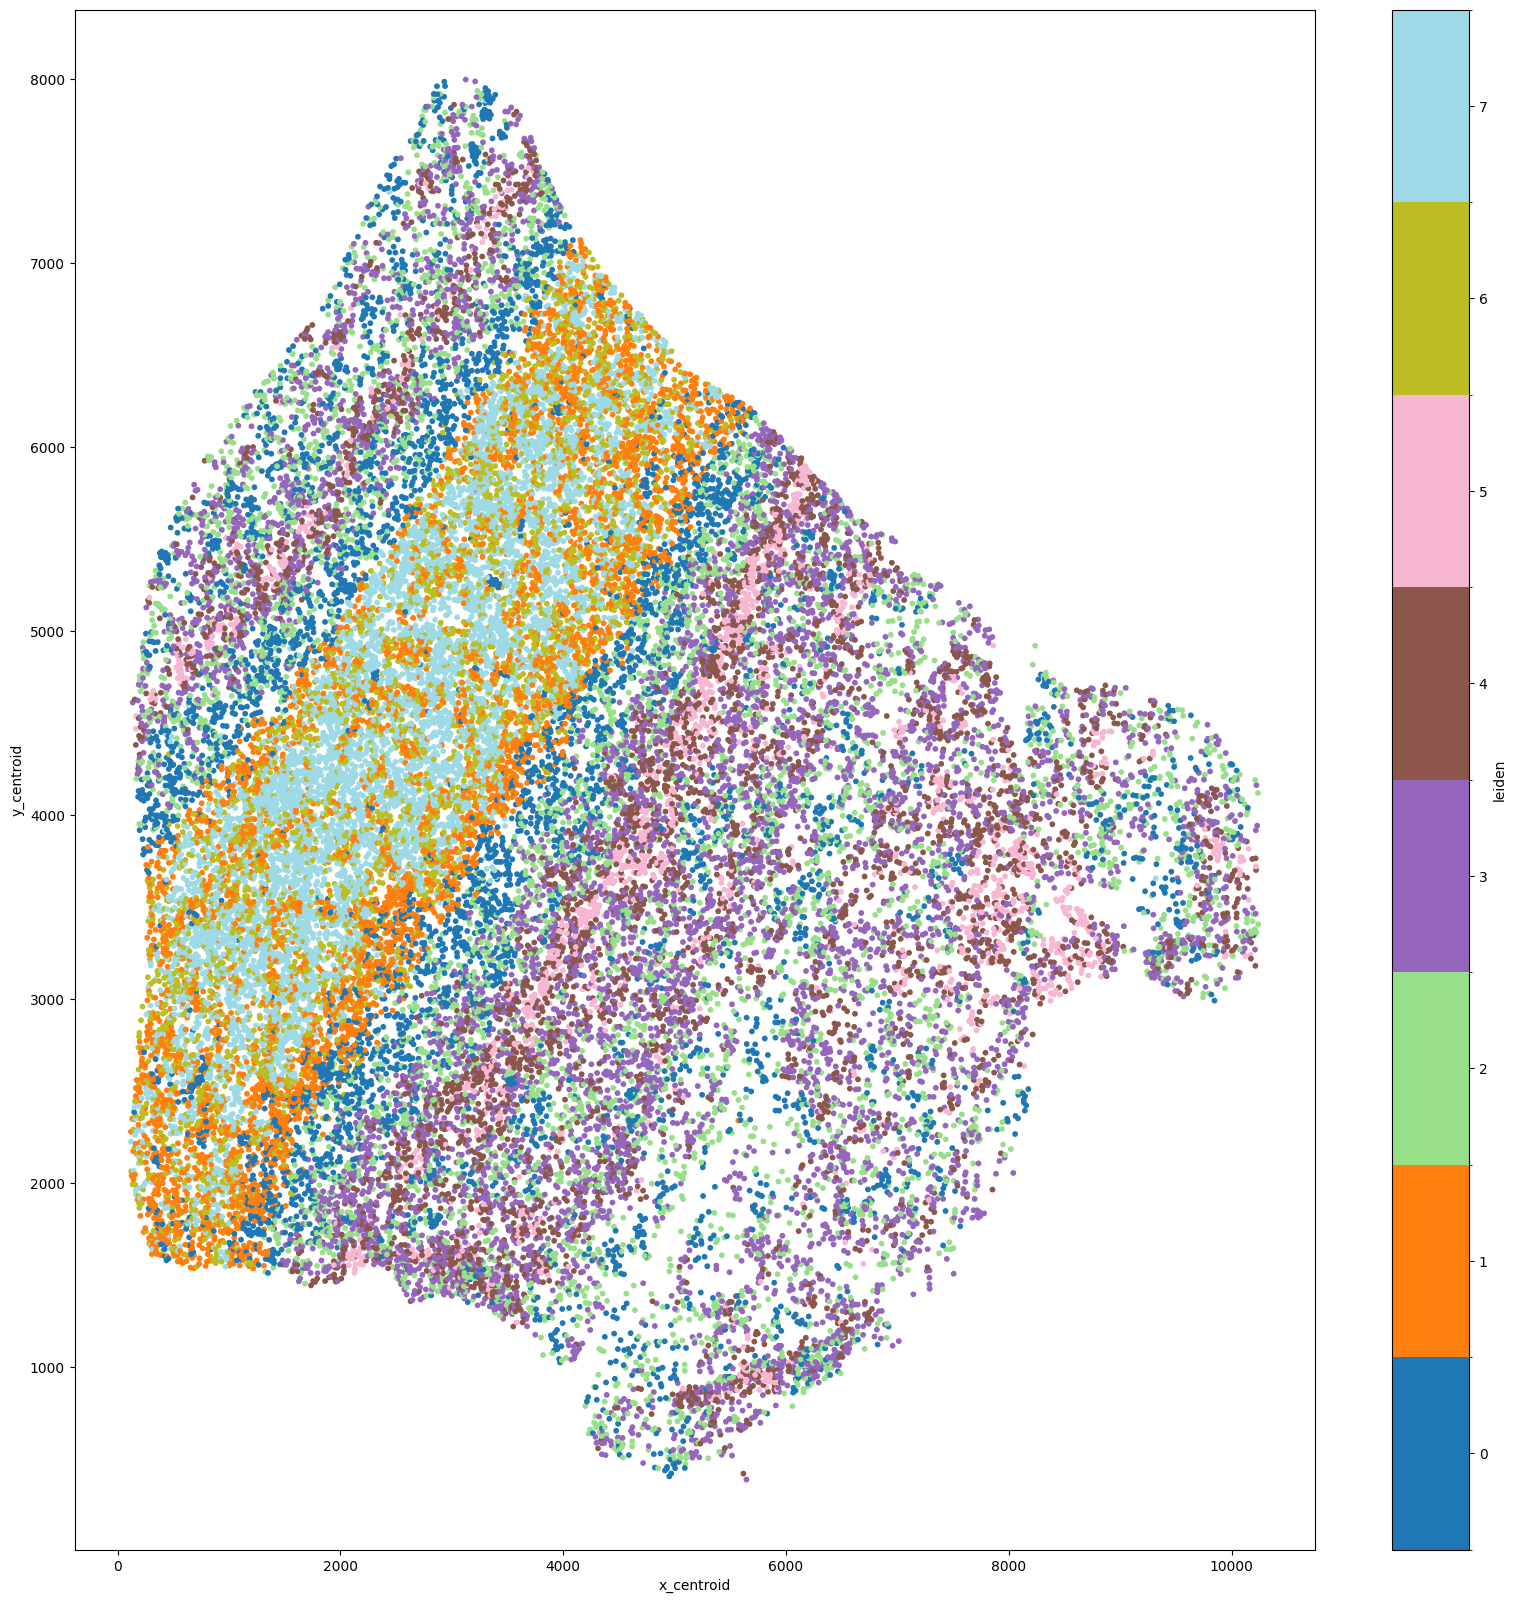

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
test_adata[test_adata.obs["folder"].eq("05-27")].obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="leiden",
    s=10,
    cmap="tab20",
    ax=acounts.div(counts.sum(axis=1), axis=0)x
)

In [209]:
import seaborn as sns
counts = test_adata[test_adata.obs["folder"].eq("05-27")].obs.pivot_table(
    index="cell_type",
    columns="leiden",
    aggfunc="size"
)


/tmp/ipykernel_3995046/2010910821.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts = test_adata[test_adata.obs["folder"].eq("05-27")].obs.pivot_table(


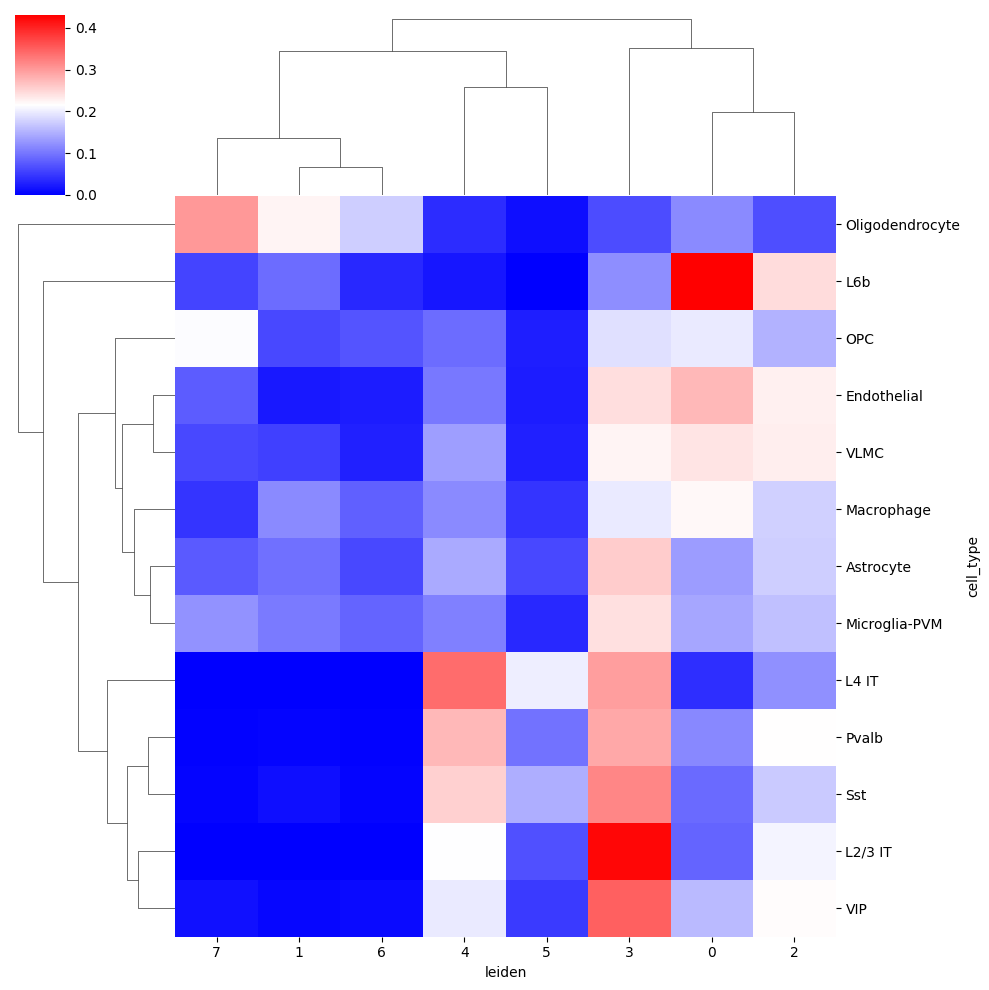

In [210]:

sns.clustermap(
    counts.div(counts.sum(axis=1), axis=0),
    cmap="bwr"
)

leiden                  0         1         2         3         4         5
cell_type                                                                  
Pvalb            0.211382  0.351626  0.426829  0.006098  0.002033  0.002033
L4 IT            0.084799  0.307789  0.607412  0.000000  0.000000  0.000000
Oligodendrocyte  0.150709  0.082370  0.065213  0.190622  0.386987  0.124100
L2/3 IT          0.186316  0.387368  0.425614  0.000000  0.000351  0.000351
Astrocyte        0.220200  0.266601  0.281030  0.084112  0.123299  0.024758
Endothelial      0.395449  0.295835  0.179047  0.023615  0.062688  0.043366
Sst              0.161507  0.325034  0.491925  0.010767  0.009421  0.001346
Microglia-PVM    0.214810  0.258262  0.206854  0.093635  0.166463  0.059976
VLMC             0.347826  0.294237  0.208291  0.053589  0.068756  0.027300
VIP              0.260121  0.366925  0.341085  0.007752  0.014643  0.009475
Macrophage       0.286765  0.250000  0.205882  0.125000  0.102941  0.029412
OPC              0.271837  0.222892  0.156627  0.057229  0.164910  0.126506
L6b              0.564972  0.216102  0.029661  0.086158  0.084746  0.018362